### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    Arya Araban

**Student ID:**     1439683

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [134]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from google.colab.patches import cv2_imshow
import math
from keras.callbacks import EarlyStopping
import cv2

In [3]:
# I created this notebook in a Google Colab Enviornment
# Make sure to place the scene32.zip in the root path. and then extract it with the following command
%%capture
!unzip "scene32.zip"

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [31]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 40

# Data generator for training

# Additional data augmentation may be added here if desired
train_datagen = ImageDataGenerator(
    rescale=1./255)

train_datagen_augmented = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.15,
      height_shift_range=0.15,
      horizontal_flip=True,
      zoom_range=0.2)

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale=1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

train_data_augmented = train_datagen_augmented.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


In [42]:
# Model input
img_input = layers.Input(shape=(32, 32, 3))

# First convolutional block
x = layers.Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu')(img_input)
x = layers.Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding='valid')(x)

# Flatten output for fully connected layers
x = layers.Flatten()(x)

# Fully connected layers
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(8, activation='softmax')(x)

# Build model
model = keras.Model(img_input, output)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/30
36/36 [==============================] - 5s 103ms/step - loss: 1.8506 - accuracy: 0.3292 - val_loss: 1.5226 - val_accuracy: 0.4938
Epoch 2/30
36/36 [==============================] - 5s 133ms/step - loss: 1.5448 - accuracy: 0.4597 - val_loss: 1.3296 - val_accuracy: 0.5312
Epoch 3/30
36/36 [==============================] - 4s 104ms/step - loss: 1.3696 - accuracy: 0.5208 - val_loss: 1.2653 - val_accuracy: 0.5094
Epoch 4/30
36/36 [==============================] - 3s 94ms/step - loss: 1.2589 - accuracy: 0.5667 - val_loss: 1.2122 - val_accuracy: 0.5719
Epoch 5/30
36/36 [==============================] - 4s 123ms/step - loss: 1.1524 - accuracy: 0.6035 - val_loss: 1.0547 - val_accuracy: 0.6281
Epoch 6/30
36/36 [==============================] - 4s 118ms/step - loss: 1.0863 - accuracy: 0.6139 - val_loss: 1.0745 - val_accuracy: 0.6375
Epoch 7/30
36/36 [==============================] - 3s 93ms/step - loss: 1.0444 - accuracy: 0.6347 - val_loss: 1.0982 - val_accuracy: 0.6125
Epoch 8/

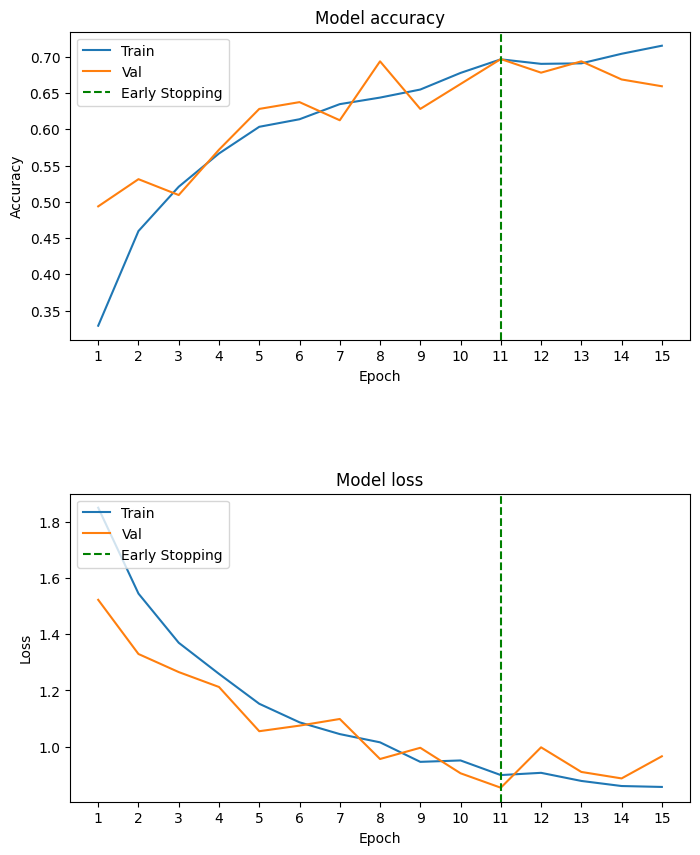

In [49]:
# Define early stopping callback
patience = 4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

num_epochs = 30
# Train model "AUGMENTED" with early stopping
history = model.fit(train_data_augmented,
                    validation_data=val_data,
                    epochs=num_epochs,
                    callbacks=[early_stopping])

plt.figure(figsize=(8, 10))  # Set the figure size as desired
x_lngth = len(history.history['accuracy'])
# Plot training & validation accuracy

plt.subplot(2, 1, 1)  # Create the first subplot
plt.plot(range(1, x_lngth + 1), history.history['accuracy'])
plt.plot(range(1, x_lngth + 1), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

if x_lngth != num_epochs:
  plt.axvline(x=x_lngth-patience, color='g', linestyle='--')
  plt.legend(['Train', 'Val', 'Early Stopping'], loc='upper left')

else:
  plt.legend(['Train', 'Val'], loc='upper left')

plt.xticks(range(1, len(history.history['accuracy']) + 1))


# Plot training & validation loss

plt.subplot(2, 1, 2)  # Create the second subplot
plt.plot(range(1, x_lngth + 1), history.history['loss'])
plt.plot(range(1, x_lngth + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

if x_lngth != num_epochs:
  plt.axvline(x=x_lngth-patience, color='g', linestyle='--')
  plt.legend(['Train', 'Val', 'Early Stopping'], loc='upper left')

else:
  plt.legend(['Train', 'Val'], loc='upper left')

plt.xticks(range(1, len(history.history['loss']) + 1))


plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

plt.show()

### 2. Error anaylsis

In [51]:
test_loss, test_acc = model.evaluate(test_data, verbose = False)

print('Overall Test Accuracy:', test_acc)
print("----")


# Get predictions on test set
predictions = model.predict(test_data)


test_labels = test_data.labels

# Calculate overall test accuracy
test_acc = accuracy_score(test_labels, predictions.argmax(axis=1))
print(f'Overall accuracy: {test_acc*100:.2f}%')

# Calculate per-class accuracy
class_names_and_indices = test_data.class_indices
class_accs = []

for c in range(len(class_names_and_indices)):

  # Get samples for this class
  y_true = test_data.labels[test_data.labels == c]
  y_pred = predictions[test_data.labels == c]

  # Calculate and append accuracy for this class
  class_acc = accuracy_score(y_true, y_pred.argmax(axis=1))
  class_accs.append(class_acc)


# Print per-class accuracies
for class_name, idx in class_names_and_indices.items():
  print(f'Class {idx} ({class_name}) accuracy: {class_accs[idx]*100:.2f}%')

Overall Test Accuracy: 0.765625
----
8/8 [==============================] - 0s 27ms/step
Overall accuracy: 76.56%
Class 0 (coast) accuracy: 70.00%
Class 1 (forest) accuracy: 80.00%
Class 2 (highway) accuracy: 77.50%
Class 3 (insidecity) accuracy: 75.00%
Class 4 (mountain) accuracy: 62.50%
Class 5 (opencountry) accuracy: 65.00%
Class 6 (street) accuracy: 90.00%
Class 7 (tallbuilding) accuracy: 92.50%


In [ ]:
def show_image_range_by_class(class_name, start_index, end_index):
    # Get the class label for the given class name from the class indices
    class_label = class_names_and_indices[class_name]

    # Find the indices of the images with the specified class label and within the specified range
    target_indices = []
    for images, labels in test_data:
        label_indices = np.argmax(labels, axis=1)
        class_indices = np.where(label_indices == class_label)[0]
        target_indices.extend(class_indices)

        if len(target_indices) >= end_index + 1:
            break

    target_indices = target_indices[start_index:end_index + 1]

    if len(target_indices) > 0:
        # Extract the corresponding images
        target_images = [images[idx] for idx in target_indices]

        # Create a horizontally stacked plot for the images
        num_images = len(target_images)
        fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

        # Plot each image in a separate subplot
        for i, ax in enumerate(axes):
            ax.imshow(target_images[i])
            ax.axis('off')

        plt.show()
    else:
        print(f"No images found for class '{class_name}' in the specified range.")

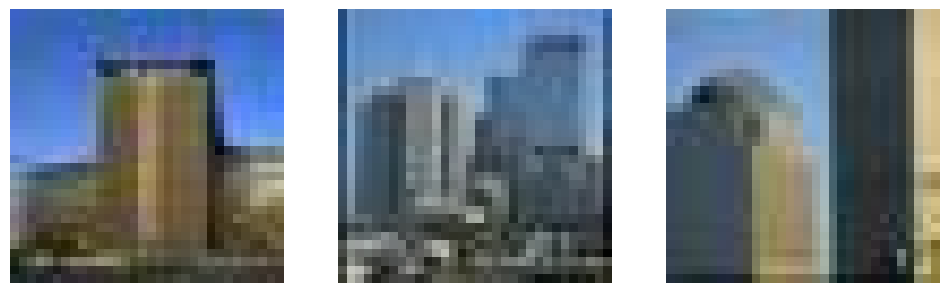


---



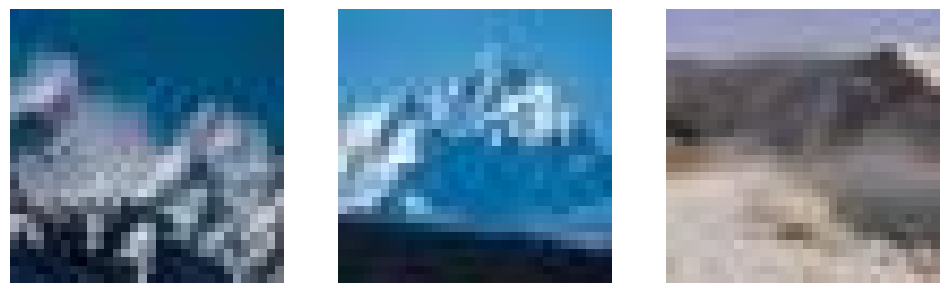


---



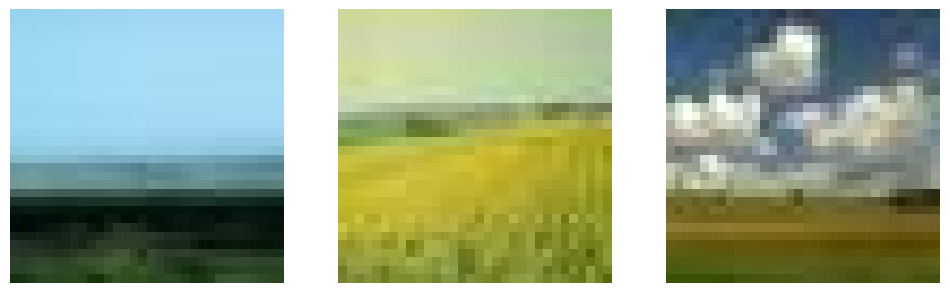

In [ ]:
show_image_range_by_class('tallbuilding',24,26)
print("\n---\n")
show_image_range_by_class('mountain',30,32)
print("\n---\n")
show_image_range_by_class('opencountry',43,45)

### 3. Kernel engineering

In [238]:

kernel_sizes = [3, 5, 7, 9]
conv_weights = []
models = []

for idx, k in enumerate(kernel_sizes):

  print(f'Training with kernel size: {k}x{k}')

  # Create model with kernel size k
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=16, kernel_size=k,
                                padding='same',
                                activation='relu',
                                input_shape=(32,32,3)))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(8, activation='softmax'))

  # Compile and train model
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  model.fit(train_data, validation_data=val_data, epochs=5)

  # Append conv weights
  conv_weights.append(model.layers[0].get_weights()[0])
  models.append(model)
  # Evaluate on test set
  loss, acc = model.evaluate(test_data)
  print(f'Test accuracy: {acc*100:.2f}%')

  print("\n~~~\n")

Training with kernel size: 3x3
Epoch 1/5
36/36 [==============================] - 3s 54ms/step - loss: 1.9264 - accuracy: 0.2847 - val_loss: 1.7221 - val_accuracy: 0.4031
Epoch 2/5
36/36 [==============================] - 2s 49ms/step - loss: 1.5578 - accuracy: 0.4618 - val_loss: 1.4794 - val_accuracy: 0.4906
Epoch 3/5
36/36 [==============================] - 3s 74ms/step - loss: 1.3410 - accuracy: 0.5431 - val_loss: 1.3854 - val_accuracy: 0.5437
Epoch 4/5
36/36 [==============================] - 3s 74ms/step - loss: 1.1944 - accuracy: 0.6097 - val_loss: 1.2258 - val_accuracy: 0.5938
Epoch 5/5
8/8 [==============================] - 0s 28ms/step - loss: 1.1191 - accuracy: 0.6031
Test accuracy: 60.31%

~~~

Training with kernel size: 5x5
Epoch 1/5
36/36 [==============================] - 3s 68ms/step - loss: 1.9385 - accuracy: 0.2660 - val_loss: 1.7252 - val_accuracy: 0.4719
Epoch 2/5
36/36 [==============================] - 2s 63ms/step - loss: 1.5529 - accuracy: 0.4785 - val_loss: 1.53

Show avg kernel across different sizes

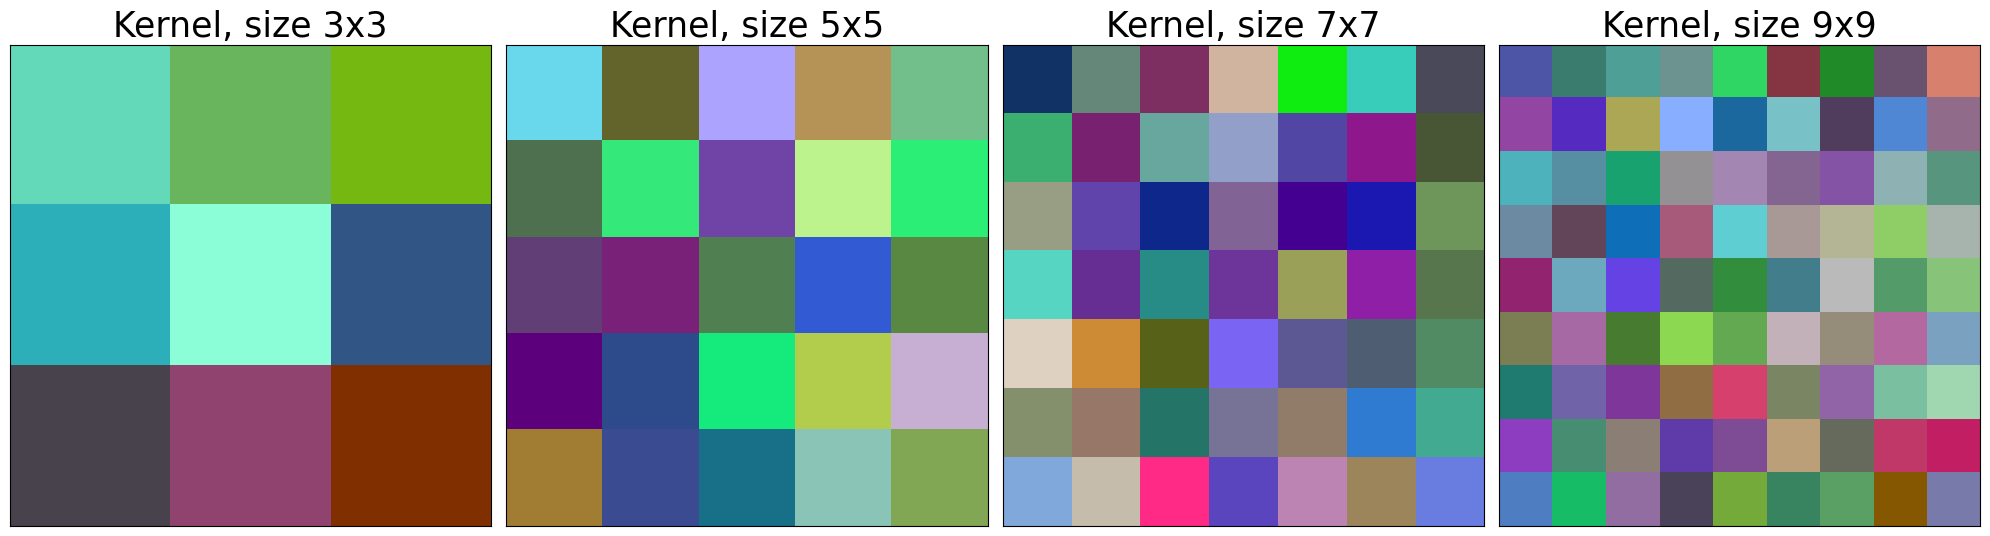

In [221]:
avg_kernels = []

plt.figure(figsize=(20, 10))
num_filters = conv_weights[0].shape[-1]
for i in range(len(conv_weights)):
    avg_kernel = np.zeros(conv_weights[i].shape[:-1])
    for j in range(num_filters): #num filters
      avg_kernel += conv_weights[i][:, :, :, j]  # Take RGB channels from first kernel of each of the different sizes
    avg_kernel /= num_filters

    kernel = avg_kernel

    #rescale the avg kernel.
    kernel_min = np.min(kernel)
    kernel_max = np.max(kernel)
    kernel_rescaled = (kernel - kernel_min) * (255.0 / (kernel_max - kernel_min))
    kernel_rescaled = np.clip(kernel_rescaled, 0, 255).astype(np.uint8)

    avg_kernels.append(kernel_rescaled)

    plt.subplot(1, len(conv_weights), i + 1)
    plt.imshow(kernel_rescaled)
    plt.title(f'Kernel, size {kernel_sizes[i]}x{kernel_sizes[i]}', fontsize=25)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


convolve those kernels on a test image

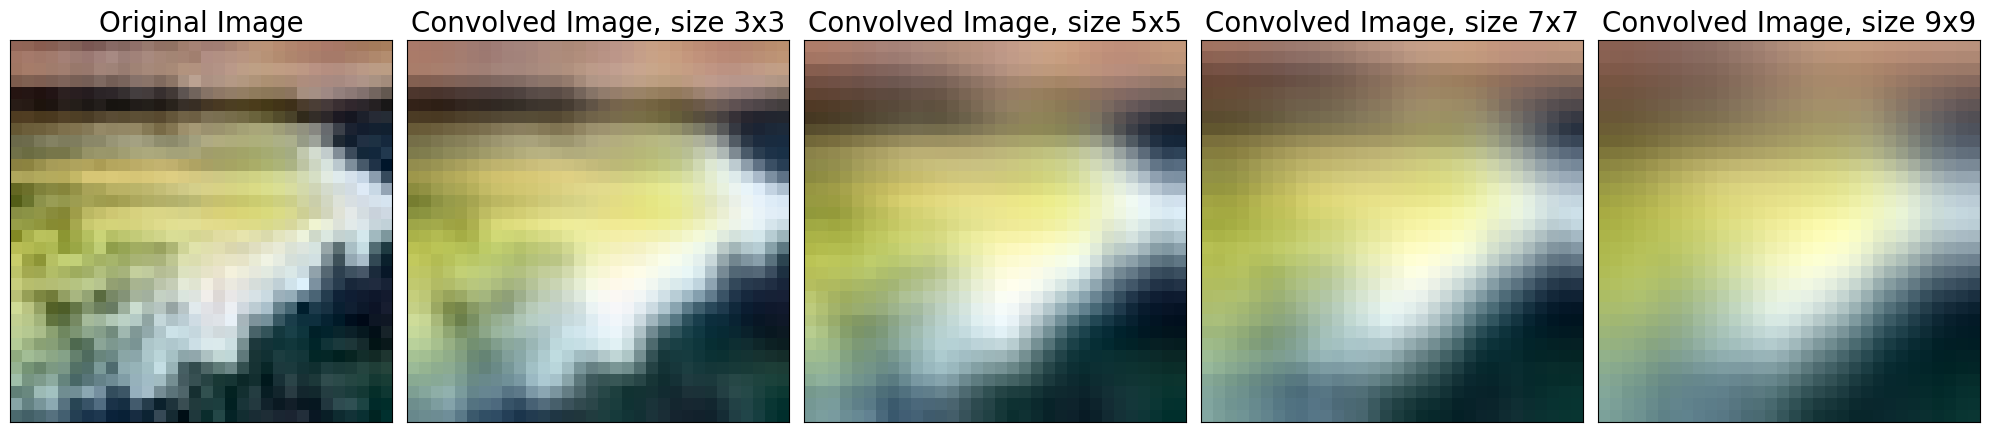

In [235]:
# Load the image
image_index = 10  # Index of the image in the test set
image_path = test_data.filepaths[image_index]
image = cv2.imread(image_path)

# Convert the image to the desired input shape for convolution
image = cv2.resize(image, (32, 32))
image = image / 255.0  # Normalize the pixel values to the range [0, 1]

# Apply convolution on the image using different kernel sizes
kernel_sizes = [3, 5, 7, 9]
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, len(kernel_sizes) + 1, 1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title('Original Image', fontsize=20)

# Convolve the image with each kernel size and plot the results
for i in range(len(kernel_sizes)):
    kernel_size = kernel_sizes[i]
    kernel = avg_kernels[i]
    kernel_2d = np.mean(kernel, axis=-1)
    convolved_image = cv2.filter2D(image, -1, kernel_2d)

    # Rescale the convolved image to the valid range [0, 255]
    convolved_image = (convolved_image - np.min(convolved_image)) * (255.0 / (np.max(convolved_image) - np.min(convolved_image)))
    convolved_image = np.clip(convolved_image, 0, 255).astype(np.uint8)

    plt.subplot(1, len(kernel_sizes) + 1, i + 2)
    plt.imshow(convolved_image)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Convolved Image, size {kernel_size}x{kernel_size}', fontsize=20)

plt.tight_layout()
plt.show()